# Import Modules

In [44]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct, idct
import bitarray.util as bit
import bitarray
import os

# Implementation

### DCT

In [45]:
def padding_img(img: np.ndarray):
    nLines, nCols = img.shape
    
    pad_row = 0 if nLines % 8 == 0 else 8 - nLines % 8
    pad_col = 0 if nCols % 8 == 0 else 8 - nCols % 8

    pad_width = ((0, pad_row), (0, pad_col)) # 
    return np.pad(img, pad_width, mode='edge') 

In [46]:
'''
DCT Function
Description:
    Calculate the transformed of a image, breaking it in bloks of 8x8
    Use two times the dct for 1D, each time for one axis of the image
Input: Original image
Output: image transformed
Warning: Need to deal with images that are not multiple of 8
'''

def DCT(img):
    Y = np.zeros(img.shape)

    nLines, nCols = img.shape
    U = nLines//8
    V = nCols//8

    for u in range(U):
        for v in range(V):
            # img_blck = np.float32(imf[u*8: u*8 + 8, v*8: v*8 + 8]) # float conversion
            img_blck = img[u*8: u*8 + 8, v*8: v*8 + 8]
            # Y[u*8: u*8 + 8, v*8: v*8 + 8] = cv.dct(img_blck)
            Y[u*8: u*8 + 8, v*8: v*8 + 8] = dct(dct(img_blck, axis=0, norm='ortho'), axis=1, norm='ortho')
    
    return Y

def iDCT(Y):

    U = Y.shape[0]//8
    V = Y.shape[1]//8
    img_rec = np.zeros(Y.shape)
    for u in range(U):
        for v in range(V):
            # img_rec[u*8 : u*8 + 8, v*8 : v*8 + 8] = cv.idct(Y[u*8 : u*8 + 8, v*8 : v*8 + 8])
            img_rec[u*8 : u*8 + 8, v*8 : v*8 + 8] = idct(idct(Y[u*8 : u*8 + 8, v*8 : v*8 + 8], axis=0, norm='ortho'), axis=1, norm='ortho')
    
    # for i in range(img_rec.shape[0]):
    #     for j in range(img_rec.shape[1]):
    #         img_rec[i][j] = 0 if img_rec[i][j] < 0 else img_rec[i][j]
    #         img_rec[i][j] = 255 if img_rec[i][j] > 255 else img_rec[i][j]



    for i in range(img_rec.shape[0]):
        for j in range(img_rec.shape[1]):
            img_rec[i][j] = -128 if img_rec[i][j] < -128 else img_rec[i][j]
            img_rec[i][j] = 127 if img_rec[i][j] > 127 else img_rec[i][j]
    
    return img_rec.astype(int)

In [47]:
def quantiza(matrix):
    quantization_jpeg = np.array([
        [8, 6, 5, 8, 12, 20, 26, 31],
        [6, 6, 7, 10, 13, 29, 30, 28],
        [7, 7, 8, 12, 20, 29, 35, 28],
        [7, 9, 11, 15, 26, 44, 40, 31],
        [9, 11, 19, 28, 34, 55, 52, 39],
        [12, 18, 28, 32, 41, 52, 57, 46],
        [25, 32, 39, 44, 52, 61, 60, 51],
        [36, 46, 48, 49, 56, 50, 52, 50],
    ])
    matrixCpy = np.copy(matrix)
    M, N = matrix.shape

    U = M //8
    V = N //8

    for i in range(U):
        for j in range(V):
            matrixCpy[i*8 : i*8 + 8, j*8 : j*8 + 8] = np.trunc(matrixCpy[i*8 : i*8 + 8, j*8 : j*8 + 8] / quantization_jpeg)

    interval = int(matrixCpy.max() - matrixCpy.min())
    
    if interval > 255:
        matrixCpy *= 255 / interval

    return np.trunc(matrixCpy).astype(int), interval

In [48]:
def dequantiza(matrix, interval: int):
    quantization_jpeg = np.array([
        [8, 6, 5, 8, 12, 20, 26, 31],
        [6, 6, 7, 10, 13, 29, 30, 28],
        [7, 7, 8, 12, 20, 29, 35, 28],
        [7, 9, 11, 15, 26, 44, 40, 31],
        [9, 11, 19, 28, 34, 55, 52, 39],
        [12, 18, 28, 32, 41, 52, 57, 46],
        [25, 32, 39, 44, 52, 61, 60, 51],
        [36, 46, 48, 49, 56, 50, 52, 50],
    ])
    
    if interval > 255:
        matrix = matrix * interval / 255


    dequantMatrix = np.zeros(matrix.shape, dtype=np.float32)
    M, N = matrix.shape
    U = M //8
    V = N //8

    for i in range(U):
        for j in range(V):
            # dequantMatrix[i*8 : i*8 + 4, j*8 : j*8 + 4] =  matrix[i*4 : i*4 + 4, j*4 : j*4 + 4]
            dequantMatrix[i*8 : i*8 + 8, j*8 : j*8 + 8] = (matrix[i*8 : i*8 + 8, j*8 : j*8 + 8] * quantization_jpeg)
    
    return dequantMatrix

In [49]:
# função para compressão
# input_image_file: arquivo de entrada contendo a imagem
# compressed_file: arquivo de saída contendo a imagem comprimida
def compress_image(input_image_file: str, compressed_file: str):
# código da função
    img = cv.imread(input_image_file, cv.IMREAD_GRAYSCALE)

    # Converte para ponto flutuante
    img = np.float32(img)

    # Centraliza a Imagem
    img = img - 128

    img = padding_img(img)

    dct_img = DCT(img)

    dct_quant, interval = quantiza(dct_img)

    minValue = dct_quant.min()
    minValue = abs(minValue) if minValue < 0 else 0

    dct_quant += minValue

    M, N = dct_quant.shape

    header = np.array([M, N], dtype=np.uint16)

    # #Create compressed binary file
    outFile = open(compressed_file, 'wb')

    for byte in header:
        num = bitarray.bitarray('0'*(16 - len(bin(byte)[2:])) + bin(byte)[2:])
        outFile.write(num)
    num = bitarray.bitarray('0'*(8 - len(bin(minValue)[2:])) + bin(minValue)[2:])
    outFile.write(num)

    num = bitarray.bitarray('0'*(8 - len(bin(interval)[2:])) + bin(interval)[2:])
    outFile.write(num)
    

    binaryStr = ''
    lenBits = 0
    for i in range(M):
        for j in range(N):
            if dct_quant[i][j] == minValue:
                binaryStr += '0'
                lenBits += 1
            else:
                value = dct_quant[i][j]
                binaryStr += '1' + '0'*(8 - len(bin(value)[2:])) + bin(value)[2:]
                lenBits += 9
            
            if lenBits >= 8:
                bytesToSend = lenBits//8
                body = bitarray.bitarray(binaryStr[0:8*bytesToSend])
                binaryStr = binaryStr[bytesToSend*8:]
                lenBits = len(binaryStr)
                outFile.write(body)
    
    if lenBits >= 8:
        bytesToSend = lenBits//8
        body = bitarray.bitarray(binaryStr[0:8*bytesToSend])
        binaryStr = binaryStr[bytesToSend*8:]
        lenBits = len(binaryStr)
        outFile.write(body)
            
    restToSend = lenBits%8
    if restToSend > 0:
        binaryStr += '0'*(8 - len(binaryStr))
        body = bitarray.bitarray(binaryStr)
        outFile.write(body)
    outFile.close()

In [50]:
def concatBytes(list):
    binStr = ''
    for i in range(len(list)):
        byte = bin(list[i])[2:]
        byte = '0' * (8 - len(byte)) + byte 
        binStr += byte

    if len(binStr) == 0:
        dic = {
            "str": binStr
        }
        return dic
    else:
        bitArr = bitarray.bitarray(binStr)
        dic = {
            "bitarray": bitArr,
            "int": bit.ba2int(bitArr),
            "str": binStr
        }
        return dic

In [51]:
# função para descompressão
# compressed_file: arquivo contendo a imagem comprimida
# output_image_file: arquivo contendo a imagem reconstruída
def decompress_image(compressed_file: str, output_image_file: str):

    with open(compressed_file, 'rb') as f:
        M = concatBytes(f.read(2))['int']
        N = concatBytes(f.read(2))['int']

        minValue = concatBytes(f.read(1))['int']
        interval = concatBytes(f.read(1))['int']

        Y_quant = np.zeros(M*N)

        i = 0
        bodyStr = concatBytes(f.read(1))['str']
        while True:
            if i >= M*N:
                break
            if len(bodyStr) <= 1:
                readBlck = f.read(1)
                if len(readBlck) == 0:
                    break
                bodyStr += concatBytes(readBlck)['str']
            
            if bodyStr[0] == '0': 
                Y_quant[i] = minValue
                bodyStr = bodyStr[1:]
            else:
                if len(bodyStr) < 9:
                    readBlck = f.read(1)
                    bodyStr += concatBytes(readBlck)['str']
                bodyStr = bodyStr[1:]
                byteStr = bodyStr[0:8]
                bitArr = bitarray.bitarray(byteStr)
                integer = bit.ba2int(bitArr)
                Y_quant[i] = integer
                bodyStr = bodyStr[8:]
            i += 1
        
        while len(bodyStr) != 0:
            if i >= M*N:
                break
            Y_quant[i] = minValue
            bodyStr = bodyStr[1:]
            i += 1


        dct_quant = Y_quant.reshape((M,N)).astype(int)
        dct_quant -= minValue

        
        dct_dequant = dequantiza(dct_quant, interval)


        # dct_dequant = np.float32(dct_dequant)
        imgRec = iDCT(dct_dequant)


        imgRec += 128


        # plt.imshow(imgRec, cmap='gray')
        cv.imwrite(output_image_file, imgRec)
#2073600

## Análises

PSNR: 34.82378830301792
compression: 3.604731209712748


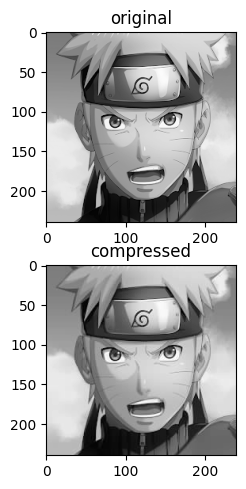

In [52]:
compress_image('imgs/naruto.webp', 'compressed.bin')
decompress_image('compressed.bin', 'out.jpg')

realImg = cv.imread('imgs/naruto.webp', cv.IMREAD_GRAYSCALE)
compressedImg = cv.imread('out.jpg', cv.IMREAD_GRAYSCALE)

MSE = ((realImg - compressedImg)**2).sum()/realImg.size
print(f'PSNR: {10*np.log10(255**2/MSE)}')

compress_size = os.stat('./compressed.bin').st_size
print(f'compression: {realImg.size / compress_size}')

fig, axs = plt.subplots(2)
fig.tight_layout(pad=1.0)
axs[0].set_title('original')
axs[0].imshow(realImg, cmap='gray')
axs[1].set_title('compressed')
axs[1].imshow(compressedImg, cmap='gray')
plt.show()

PSNR: 37.47343193922978
compression: 4.114908829051257


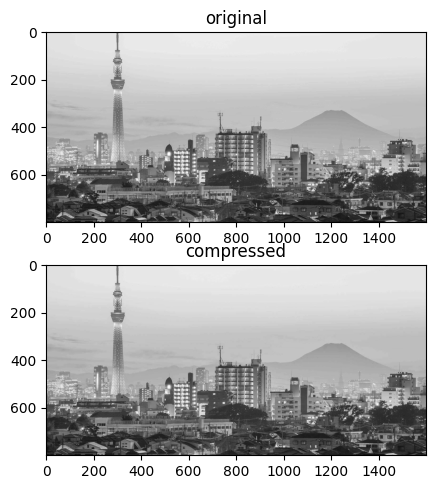

In [53]:

compress_image('imgs/sky_tree.jpg', 'compressed.bin')
decompress_image('compressed.bin', 'out.jpg')

realImg = cv.imread('imgs/sky_tree.jpg', cv.IMREAD_GRAYSCALE)
compressedImg = cv.imread('out.jpg', cv.IMREAD_GRAYSCALE)
realImg = padding_img(realImg)

MSE = ((realImg - compressedImg)**2).sum()/realImg.size
print(f'PSNR: {10*np.log10(255**2/MSE)}')
compress_size = os.stat('./compressed.bin').st_size
print(f'compression: {realImg.size / compress_size}')



fig, axs = plt.subplots(2)
fig.tight_layout(pad=1.0)
axs[0].set_title('original')
axs[0].imshow(realImg, cmap='gray')
axs[1].set_title('compressed')
axs[1].imshow(compressedImg, cmap='gray')
plt.show()

PSNR: 33.68208357644956
compression: 3.3222197477894326


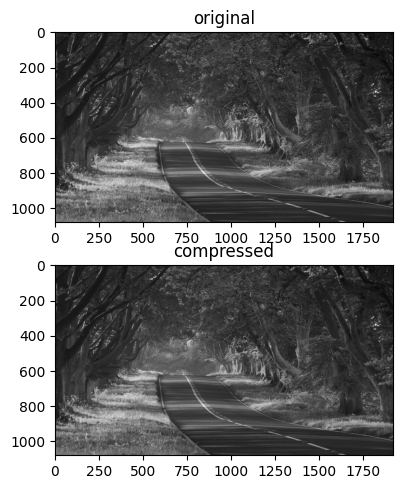

In [54]:
compress_image('imgs/highway.jpg', 'compressed.bin')
decompress_image('compressed.bin', 'out.jpg')

realImg = cv.imread('imgs/highway.jpg', cv.IMREAD_GRAYSCALE)
compressedImg = cv.imread('out.jpg', cv.IMREAD_GRAYSCALE)
realImg = padding_img(realImg)

MSE = ((realImg - compressedImg)**2).sum()/realImg.size
print(f'PSNR: {10*np.log10(255**2/MSE)}')
compress_size = os.stat('./compressed.bin').st_size
print(f'compression: {realImg.size / compress_size}')

fig, axs = plt.subplots(2)
fig.tight_layout(pad=1.0)
axs[0].set_title('original')
axs[0].imshow(realImg, cmap='gray')
axs[1].set_title('compressed')
axs[1].imshow(compressedImg, cmap='gray')
plt.show()

PSNR: 37.47343193922978
compression: 4.114908829051257


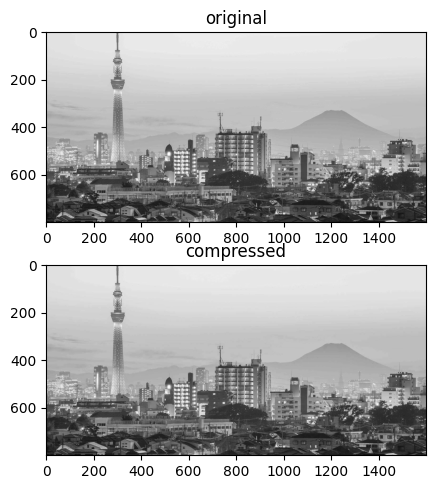

In [55]:
compress_image('imgs/sky_tree.jpg', 'compressed.bin')
decompress_image('compressed.bin', 'out.jpg')

realImg = cv.imread('imgs/sky_tree.jpg', cv.IMREAD_GRAYSCALE)
compressedImg = cv.imread('out.jpg', cv.IMREAD_GRAYSCALE) 
realImg = padding_img(realImg)

MSE = ((realImg - compressedImg)**2).sum()/realImg.size
print(f'PSNR: {10*np.log10(255**2/MSE)}')
compress_size = os.stat('./compressed.bin').st_size
print(f'compression: {realImg.size / compress_size}')

fig, axs = plt.subplots(2)
fig.tight_layout(pad=1.0)
axs[0].set_title('original')
axs[0].imshow(realImg, cmap='gray')
axs[1].set_title('compressed')
axs[1].imshow(compressedImg, cmap='gray')
plt.show()